## 实验1

首先，加载rpy2，使得R和Pyhton可以同时用

In [1]:
%load_ext rpy2.ipython

## 数据集
准备mnist数据，将其归一化和向量化

In [2]:
from keras.datasets import mnist
import numpy as np
(x_train, x_train_lab), (x_test, x_test_lab) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

print(x_train.shape)
print(x_test.shape)

Using TensorFlow backend.
/home/ncclab/anaconda3/envs/iccv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ncclab/anaconda3/envs/iccv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ncclab/anaconda3/envs/iccv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ncclab/anaconda3/env

(60000, 784)
(10000, 784)


x_train.shape表示训练数据集的shape，其中x_train.shape[0]=60000表示图片的数量·；x_train.shape[0]=784表示图片的维度大小。 x_test.shape 表示测试集的shape，意义同理训练数据集。

## DAE

首先，先建立一个全连接（dense）的编码器和解码器。参数e_dim=2表示中间的隐藏层是2维，,L1=0表示L1正则的权重。

In [3]:
from keras.layers import Input, Dense
from keras.models import Model
from keras import regularizers

def dense_autoencoder(e_dim=2,L1=0):
    # this is the size of our encoded representations
    encoding_dim = e_dim  # e_dim floats -> compression of factor 784/e_dim, assuming the input is 784 floats
    
    # this is our input placeholder
    input_img = Input(shape=(784,))
    # "encoded" is the encoded representation of the input
    encod_1 = Dense(392, activation='relu',activity_regularizer=regularizers.l1(L1))(input_img)
    encoded = Dense(encoding_dim, activation='relu',activity_regularizer=regularizers.l1(L1))(encod_1)
    # "decoded" is the lossy reconstruction of the input
    decod_1 = Dense(392, activation='relu',activity_regularizer=regularizers.l1(L1))(encoded)
    decoded = Dense(784, activation='sigmoid')(decod_1)
    
    # this model maps an input to its reconstruction
    autoencoder = Model(input=input_img, output=decoded)
    
    # this model maps an input to its encoded representation
    encoder = Model(input=input_img, output=encoded)
    
    # create a placeholder for an encoded (32-dimensional) input
    encoded_input = Input(shape=(encoding_dim,))
    # retrieve the last layer of the autoencoder model
    decoder_layer = autoencoder.layers[-2]
    # create the decoder model
    decoder = Model(input=encoded_input, output=decoder_layer(encoded_input))
    return autoencoder, encoder, decoder

下面我们训练dense全连接接自编码器，其中e_dim=2,L1=0。这里使用逐像素的交叉熵作为损失函数，优化器为adam

In [4]:
from keras import optimizers
dense_ae, dense_en, dense_de = dense_autoencoder(e_dim=100,L1=0)
opt = optimizers.Adam(lr=0.001)
dense_ae.compile(optimizer=opt, loss='binary_crossentropy')
dense_ae.fit(x_train, x_train,
                nb_epoch=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


/home/ncclab/anaconda3/envs/iccv/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
/home/ncclab/anaconda3/envs/iccv/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
/home/ncclab/anaconda3/envs/iccv/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
/home/ncclab/anaconda3/envs/iccv/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  if __name__ == '__main__':



Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 4s 69us/step - loss: 0.1799 - val_loss: 0.1082
Epoch 2/50
60000/60000 [==============================] - 3s 47us/step - loss: 0.0986 - val_loss: 0.0896
Epoch 3/50
60000/60000 [==============================] - 3s 48us/step - loss: 0.0870 - val_loss: 0.0828
Epoch 4/50
60000/60000 [==============================] - 3s 48us/step - loss: 0.0821 - val_loss: 0.0799
Epoch 5/50
60000/60000 [==============================] - 3s 47us/step - loss: 0.0789 - val_loss: 0.0773
Epoch 6/50
60000/60000 [==============================] - 3s 51us/step - loss: 0.0771 - val_loss: 0.0759
Epoch 7/50
60000/60000 [==============================] - 3s 50us/step - loss: 0.0757 - val_loss: 0.0745
Epoch 8/50
60000/60000 [==============================] - 3s 47us/step - loss: 0.0746 - val_loss: 0.0736
Epoch 9/50
60000/60000 [==============================] - 3s 48us/step - loss: 0.0736 - val_loss: 0.0727
Epoc

模型训练完成之后，我们提取中间的隐藏层的特征。

In [5]:
import numpy as np
features_dae = dense_en.predict(x_test[0:10000:1])
features_lab = []
lab = ['zero','one','two','three','four','five','six','seven','eight','nine']
for i in range(x_test_lab.shape[0]):
    for j in range(10):
        if x_test_lab[i]==j:
            features_lab.append(lab[j])
        
#features_dae = np.transpose(features_dae,(1,0))
print(features_dae.shape)
features_lab   =  np.array(features_lab).reshape(features_dae.shape[0],1) 
print(features_lab.shape)

(10000, 100)
(10000, 1)


## t-SNE

接下来对mnist数据集做t-SNE

In [6]:
from sklearn import manifold
from sklearn import decomposition
tsne = manifold.TSNE(n_components=2, init='pca',perplexity=50,early_exaggeration=3.0)
features_tsne  = tsne.fit_transform(features_dae)


In [7]:
import numpy as np
print(features_tsne.shape)
features_tsne = np.transpose(features_tsne,(1,0))
features_tsne_1 =  features_tsne[0].reshape(features_tsne.shape[1],1)
features_tsne_2 =  features_tsne[1].reshape(features_tsne.shape[1],1)
print(features_tsne_1.shape)
print(features_tsne_2.shape)
print(features_lab.shape)

(10000, 2)
(10000, 1)
(10000, 1)
(10000, 1)


In [8]:
%%R -i features_tsne_1 -o features_tsne_r1
features_tsne_r1 <- features_tsne_1

In [9]:
%%R -i features_tsne_2 -o features_tsne_r2
features_tsne_r2 <- features_tsne_2

In [10]:
%%R -i features_lab -o features_lab_r
features_lab_r <- features_lab

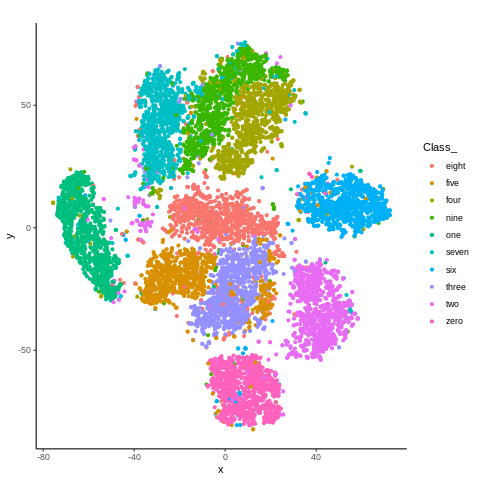

In [11]:
%%R
tsne<- data.frame(features_tsne_r1,features_tsne_r2)
tsne$Class_<- features_lab_r
#查看种类个数为9，定义9种颜色



#将降维后需要的结果转为数据框形式

library(ggplot2)

#将特征变量加入降维后的数据框
ggplot(tsne, mapping=aes(x=features_tsne_r1, y=features_tsne_r2, color=Class_)) +
  geom_point(size=1.25) +
  labs(title = "",
       x = "x",
       y = "y") +
  theme(plot.title = element_text(hjust = 0.5))+
  #geom_smooth(method="loess")+
  theme_bw() +
  theme(panel.border = element_blank(),panel.grid.major = element_blank())+
  theme(panel.grid.minor = element_blank(),axis.line = element_line(colour = "black"))

## PCA

接下来对mnist数据集做t-SNE

In [12]:
pca = decomposition.PCA(n_components=2)
features_pca =pca.fit_transform(features_dae)

In [13]:
import numpy as np
print(features_pca.shape)
features_pca = np.transpose(features_pca,(1,0))
features_pca_1 =  features_pca[0].reshape(features_pca.shape[1],1)
features_pca_2 =  features_pca[1].reshape(features_pca.shape[1],1)
print(features_pca_1.shape)
print(features_pca_2.shape)
print(features_lab.shape)

(10000, 2)
(10000, 1)
(10000, 1)
(10000, 1)


In [14]:
%%R -i features_pca_1 -o features_pca_r1
features_pca_r1 <- features_pca_1

In [15]:
%%R -i features_pca_2 -o features_pca_r2
features_pca_r2 <- features_pca_2

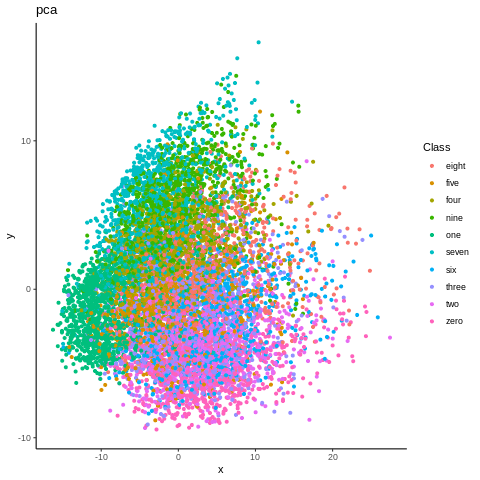

In [16]:
%%R
tsne<- data.frame(features_pca_r1,features_pca_r2)
tsne$Class<- features_lab_r
#查看种类个数为9，定义9种颜色



#将降维后需要的结果转为数据框形式

library(ggplot2)

#将特征变量加入降维后的数据框
ggplot(tsne, mapping=aes(x=features_pca_r1, y=features_pca_r2, color=Class)) +
  geom_point(size=1.25) +
  labs(title = "pca",
       x = "x",
       y = "y") +
  theme(plot.title = element_text(hjust = 0.5))+
  #geom_smooth(method="loess")+
  theme_bw() +
  theme(panel.border = element_blank(),panel.grid.major = element_blank())+
  theme(panel.grid.minor = element_blank(),axis.line = element_line(colour = "black"))

## 重构图像

In [17]:
# use Matplotlib (don't ask)
import matplotlib.pyplot as plt

def draw_img(X_orgin,X_recon):
    n = 10
    m = 2
    resolution =28
    plt.figure(figsize=(n,m)) 
    for i in range(n):
        # display original images
        ax = plt.subplot(m, n, i  + 1)
        #plt.imshow(X_reconstructed_mu_1[i].reshape(resolution ,resolution,3))
        plt.imshow(X_orgin[i].reshape(resolution ,resolution ),cmap='hot')
        #plt.imshow((X_test[i+n*500].reshape(resolution ,resolution )),cmap='hot')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        # display reconstruction image
        ax = plt.subplot(m, n, i  + n+1)
        #plt.imshow(X_reconstructed_mu_1[i].reshape(resolution ,resolution,3))
        plt.imshow(X_recon[i].reshape(resolution ,resolution ),cmap='hot')
        #plt.imshow((X_test[i+n*500].reshape(resolution ,resolution )),cmap='hot')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.0, wspace =0.05, hspace =0.05)
    #plt.savefig(os.path.join(figures,'recons.pdf'), dpi=300)
    #plt.close()
    plt.show()

## DAE
DAE 的中间的维度为100时，重构效果

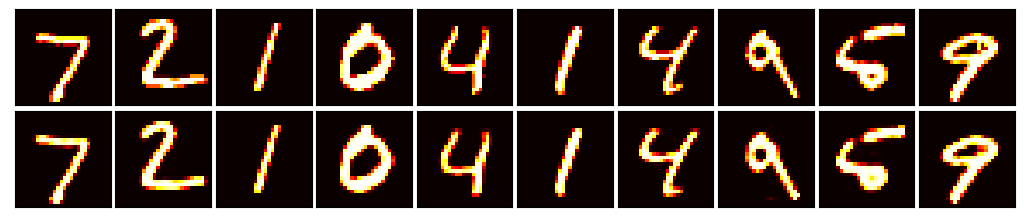

In [18]:
recon = dense_ae.predict(x_test)
x = draw_img(x_test,recon)


## DAE
DAE 的中间的维度为1时，重构效果

/home/ncclab/anaconda3/envs/iccv/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
/home/ncclab/anaconda3/envs/iccv/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
/home/ncclab/anaconda3/envs/iccv/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
/home/ncclab/anaconda3/envs/iccv/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  if __name__ == '__main__':


Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 3s 55us/step - loss: 0.2871 - val_loss: 0.2569
Epoch 2/50
60000/60000 [==============================] - 3s 44us/step - loss: 0.2520 - val_loss: 0.2460
Epoch 3/50
60000/60000 [==============================] - 3s 44us/step - loss: 0.2435 - val_loss: 0.2409
Epoch 4/50
60000/60000 [==============================] - 3s 43us/step - loss: 0.2404 - val_loss: 0.2391
Epoch 5/50
60000/60000 [==============================] - 3s 44us/step - loss: 0.2391 - val_loss: 0.2380
Epoch 6/50
60000/60000 [==============================] - 3s 44us/step - loss: 0.2381 - val_loss: 0.2368
Epoch 7/50
60000/60000 [==============================] - 3s 44us/step - loss: 0.2370 - val_loss: 0.2359
Epoch 8/50
60000/60000 [==============================] - 3s 45us/step - loss: 0.2361 - val_loss: 0.2350
Epoch 9/50
60000/60000 [==============================] - 3s 44us/step - loss: 0.2354 - val_loss: 0.2343
Epoch

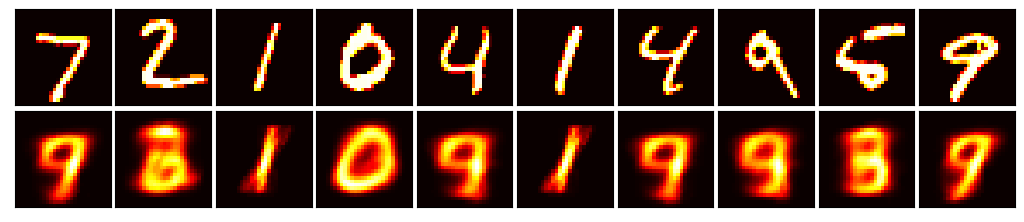

In [19]:
from keras import optimizers
dense_ae, dense_en, dense_de = dense_autoencoder(e_dim=1,L1=0)
opt = optimizers.Adam(lr=0.001)
dense_ae.compile(optimizer=opt, loss='binary_crossentropy')
dense_ae.fit(x_train, x_train,
                nb_epoch=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))
recon_1 = dense_ae.predict(x_test)
draw_img(x_test,recon_1)


## DAE
DAE 的中间的维度为2时，重构效果

/home/ncclab/anaconda3/envs/iccv/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
/home/ncclab/anaconda3/envs/iccv/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
/home/ncclab/anaconda3/envs/iccv/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
/home/ncclab/anaconda3/envs/iccv/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  if __name__ == '__main__':


Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 3s 54us/step - loss: 0.2859 - val_loss: 0.2574
Epoch 2/50
60000/60000 [==============================] - 3s 46us/step - loss: 0.2507 - val_loss: 0.2317
Epoch 3/50
60000/60000 [==============================] - 3s 46us/step - loss: 0.2244 - val_loss: 0.2173
Epoch 4/50
60000/60000 [==============================] - 3s 46us/step - loss: 0.2145 - val_loss: 0.2108
Epoch 5/50
60000/60000 [==============================] - 3s 46us/step - loss: 0.2093 - val_loss: 0.2072
Epoch 6/50
60000/60000 [==============================] - 3s 46us/step - loss: 0.2057 - val_loss: 0.2043
Epoch 7/50
60000/60000 [==============================] - 3s 45us/step - loss: 0.2026 - val_loss: 0.2015
Epoch 8/50
60000/60000 [==============================] - 3s 44us/step - loss: 0.2001 - val_loss: 0.1996
Epoch 9/50
60000/60000 [==============================] - 3s 44us/step - loss: 0.1982 - val_loss: 0.1980
Epoch

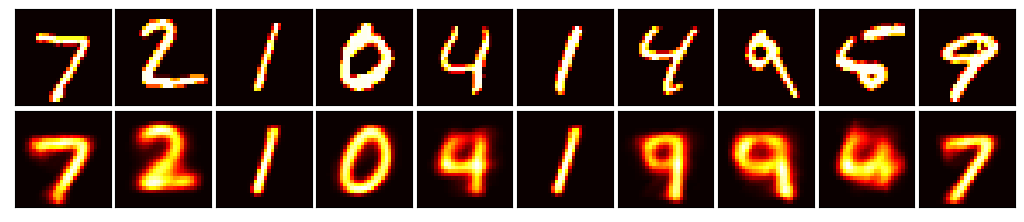

In [20]:
from keras import optimizers
dense_ae, dense_en, dense_de = dense_autoencoder(e_dim=2,L1=0)
opt = optimizers.Adam(lr=0.001)
dense_ae.compile(optimizer=opt, loss='binary_crossentropy')
dense_ae.fit(x_train, x_train,
                nb_epoch=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))
recon_2 = dense_ae.predict(x_test)
draw_img(x_test,recon_2)

## DAE
DAE 的中间的维度为10时，重构效果

/home/ncclab/anaconda3/envs/iccv/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
/home/ncclab/anaconda3/envs/iccv/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
/home/ncclab/anaconda3/envs/iccv/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
/home/ncclab/anaconda3/envs/iccv/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  if __name__ == '__main__':


Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 3s 54us/step - loss: 0.2280 - val_loss: 0.1587
Epoch 2/50
60000/60000 [==============================] - 3s 45us/step - loss: 0.1480 - val_loss: 0.1389
Epoch 3/50
60000/60000 [==============================] - 3s 45us/step - loss: 0.1365 - val_loss: 0.1321
Epoch 4/50
60000/60000 [==============================] - 3s 45us/step - loss: 0.1310 - val_loss: 0.1282
Epoch 5/50
60000/60000 [==============================] - 3s 45us/step - loss: 0.1274 - val_loss: 0.1250
Epoch 6/50
60000/60000 [==============================] - 3s 45us/step - loss: 0.1248 - val_loss: 0.1227
Epoch 7/50
60000/60000 [==============================] - 3s 45us/step - loss: 0.1227 - val_loss: 0.1210
Epoch 8/50
60000/60000 [==============================] - 3s 45us/step - loss: 0.1210 - val_loss: 0.1197
Epoch 9/50
60000/60000 [==============================] - 3s 45us/step - loss: 0.1197 - val_loss: 0.1183
Epoch

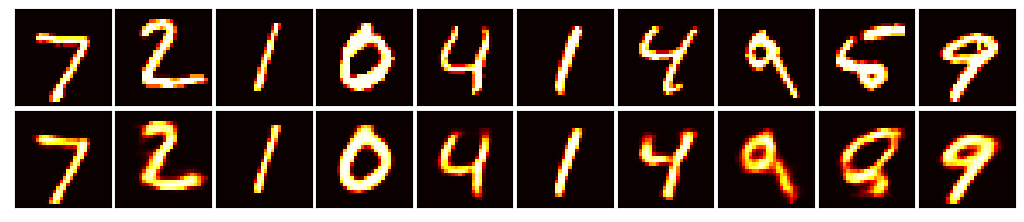

In [21]:
from keras import optimizers
dense_ae, dense_en, dense_de = dense_autoencoder(e_dim=10,L1=0)
opt = optimizers.Adam(lr=0.001)
dense_ae.compile(optimizer=opt, loss='binary_crossentropy')
dense_ae.fit(x_train, x_train,
                nb_epoch=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))
recon_10 = dense_ae.predict(x_test)
draw_img(x_test,recon_10)


## DAE
DAE 的中间的维度为50时，重构效果

/home/ncclab/anaconda3/envs/iccv/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
/home/ncclab/anaconda3/envs/iccv/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
/home/ncclab/anaconda3/envs/iccv/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
/home/ncclab/anaconda3/envs/iccv/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  if __name__ == '__main__':


Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 3s 55us/step - loss: 0.1894 - val_loss: 0.1153
Epoch 2/50
60000/60000 [==============================] - 3s 46us/step - loss: 0.1043 - val_loss: 0.0959
Epoch 3/50
60000/60000 [==============================] - 3s 46us/step - loss: 0.0923 - val_loss: 0.0880
Epoch 4/50
60000/60000 [==============================] - 3s 46us/step - loss: 0.0870 - val_loss: 0.0842
Epoch 5/50
60000/60000 [==============================] - 3s 46us/step - loss: 0.0840 - val_loss: 0.0820
Epoch 6/50
60000/60000 [==============================] - 3s 46us/step - loss: 0.0819 - val_loss: 0.0803
Epoch 7/50
60000/60000 [==============================] - 3s 46us/step - loss: 0.0806 - val_loss: 0.0794
Epoch 8/50
60000/60000 [==============================] - 3s 47us/step - loss: 0.0795 - val_loss: 0.0783
Epoch 9/50
60000/60000 [==============================] - 3s 46us/step - loss: 0.0787 - val_loss: 0.0778
Epoch

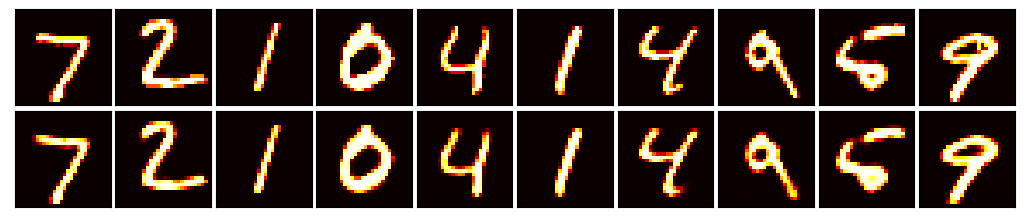

In [22]:
from keras import optimizers
dense_ae, dense_en, dense_de = dense_autoencoder(e_dim=50,L1=0)
opt = optimizers.Adam(lr=0.001)
dense_ae.compile(optimizer=opt, loss='binary_crossentropy')
dense_ae.fit(x_train, x_train,
                nb_epoch=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))
recon_50 = dense_ae.predict(x_test)
draw_img(x_test,recon_50)


## DAE
DAE 的中间的维度为1，2，10，50，100时，重构效果对比

In [25]:
# use Matplotlib (don't ask)
import matplotlib.pyplot as plt

def draw_img_5(X_recon_1,X_recon_2,X_recon_10,X_recon_50,X_recon,X_orgin):
    n = 10
    m = 6
    resolution =28
    plt.figure(figsize=(n,m)) 
    for i in range(n):
        
        # display reconstruction image
        ax = plt.subplot(m, n, i  +1)
        #plt.imshow(X_reconstructed_mu_1[i].reshape(resolution ,resolution,3))
        plt.imshow(X_recon_1[i].reshape(resolution ,resolution ),cmap='hot')
        #plt.imshow((X_test[i+n*500].reshape(resolution ,resolution )),cmap='hot')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        # display reconstruction image
        ax = plt.subplot(m, n, i  + n+1)
        #plt.imshow(X_reconstructed_mu_1[i].reshape(resolution ,resolution,3))
        plt.imshow(X_recon_2[i].reshape(resolution ,resolution ),cmap='hot')
        #plt.imshow((X_test[i+n*500].reshape(resolution ,resolution )),cmap='hot')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        # display reconstruction image
        ax = plt.subplot(m, n, i  + 2*n+1)
        #plt.imshow(X_reconstructed_mu_1[i].reshape(resolution ,resolution,3))
        plt.imshow(X_recon_10[i].reshape(resolution ,resolution ),cmap='hot')
        #plt.imshow((X_test[i+n*500].reshape(resolution ,resolution )),cmap='hot')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        # display reconstruction image
        ax = plt.subplot(m, n, i  + 3*n+1)
        #plt.imshow(X_reconstructed_mu_1[i].reshape(resolution ,resolution,3))
        plt.imshow(X_recon_50[i].reshape(resolution ,resolution ),cmap='hot')
        #plt.imshow((X_test[i+n*500].reshape(resolution ,resolution )),cmap='hot')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        # display reconstruction image
        ax = plt.subplot(m, n, i  + 4*n+1)
        #plt.imshow(X_reconstructed_mu_1[i].reshape(resolution ,resolution,3))
        plt.imshow(X_orgin[i].reshape(resolution ,resolution ),cmap='hot')
        #plt.imshow((X_test[i+n*500].reshape(resolution ,resolution )),cmap='hot')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        # display original images
        ax = plt.subplot(m, n, i + 5*n + 1)
        #plt.imshow(X_reconstructed_mu_1[i].reshape(resolution ,resolution,3))
        plt.imshow(X_recon[i].reshape(resolution ,resolution ),cmap='hot')
        #plt.imshow((X_test[i+n*500].reshape(resolution ,resolution )),cmap='hot')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.0, wspace =0.05, hspace =0.05)
    #plt.savefig(os.path.join(figures,'recons.pdf'), dpi=300)
    #plt.close()
    plt.show()

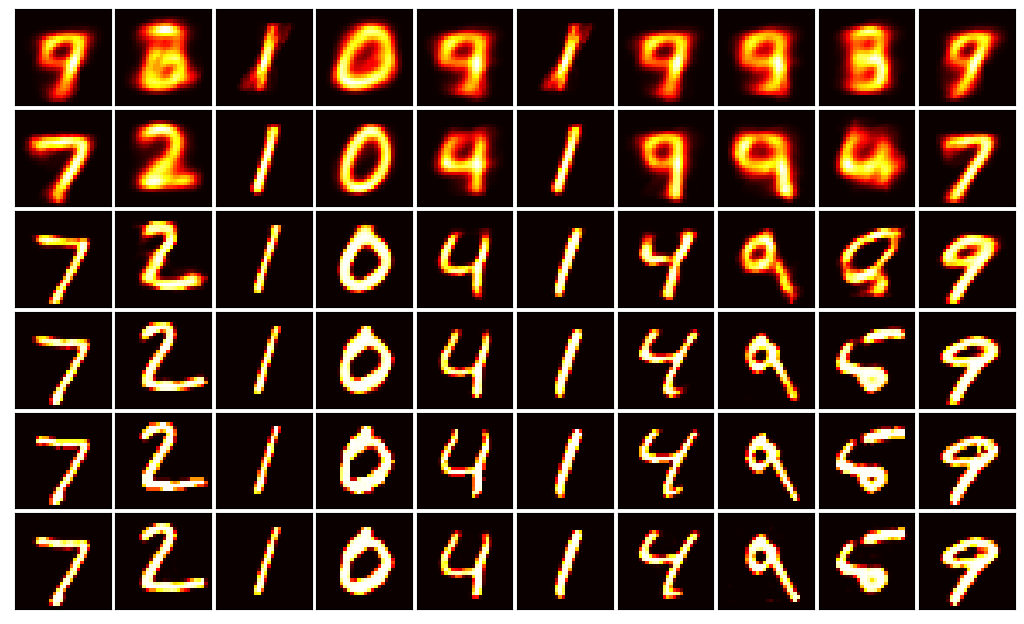

In [26]:
draw_img_5(recon_1,recon_2,recon_10,recon_50,recon,x_test)